<span style='font-size:large'>**Problem Set 3 \(Group Activity\)**</span>

**Leader:** 

**Manansala, Richard M.**

**Members:**

**Dalugdugan, Nicko R.**

**Hilario, Franniel Luigi C.**

**Magbanua, Brian Gabriel G.**

**Pasamba, Jermaine C.**

**Ventura, Fiona C.**



In [68]:
import itertools
import random
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# For reproducibility
test_seed = 42
random.seed(test_seed)
np.random.seed(test_seed)

# Generate 10 random city coordinates within a 100x100 grid
NUM_CITIES = 10
cities = {f"C{i}": (random.uniform(0, 100), random.uniform(0, 100)) for i in range(NUM_CITIES)}

# Distance function
def distance(p, q):
    return math.hypot(p[0] - q[0], p[1] - q[1])

# Precompute distance matrix
distances = {u: {v: distance(cities[u], cities[v]) for v in cities} for u in cities}

def tour_length(path):
    return sum(distances[path[i]][path[(i+1) % len(path)]] for i in range(len(path)))

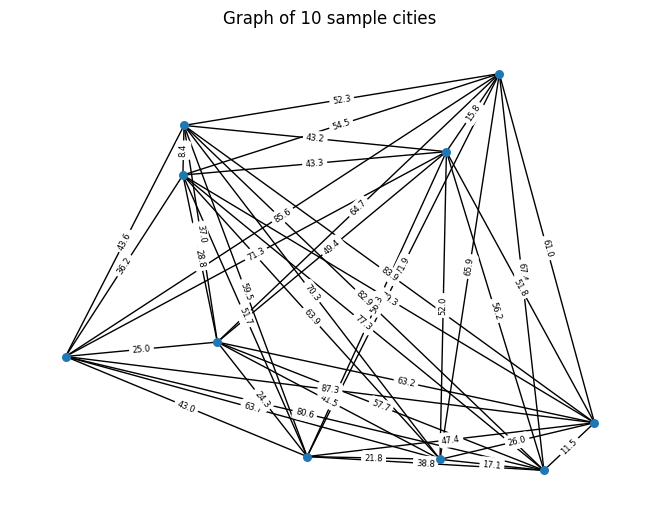

In [69]:
G = nx.Graph()
G.add_nodes_from(cities)
for u,v in itertools.combinations(cities,2):
    G.add_edge(u,v, weight=round(distances[u][v],1))
pos = {c: cities[c] for c in cities}

nx.draw(G, pos, with_labels=False, node_size=30)
edgelabels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=edgelabels,font_size=6)
plt.title('Graph of 10 sample cities')
plt.axis('off'); plt.show()

In [70]:
start = time.time()
best_length = float('inf')
best_path = None
for perm in itertools.permutations(cities):
    length = sum(distances[perm[i]][perm[(i+1)%len(cities)]] for i in range(len(cities)))
    if length < best_length:
        best_length = length
        best_path = perm
brute_time = time.time() - start
print(f"Brute Force → Length: {best_length:.2f}, Time: {brute_time:.4f}s")

Brute Force → Length: 264.14, Time: 9.3329s


## Nearest Neighbor


1. Initialize a visited list
2. Select a starting city (first in the code) and add to visited
3. Select the next closest unvisited  city and add to visited
4. Repeat step 3 until all cities are visited
5. Return the tour

Nearest Neighbor Time: 0.0000ms | Best Distance: 280.7779366357131 Path: ['C0', 'C9', 'C3', 'C4', 'C1', 'C6', 'C5', 'C8', 'C7', 'C2']


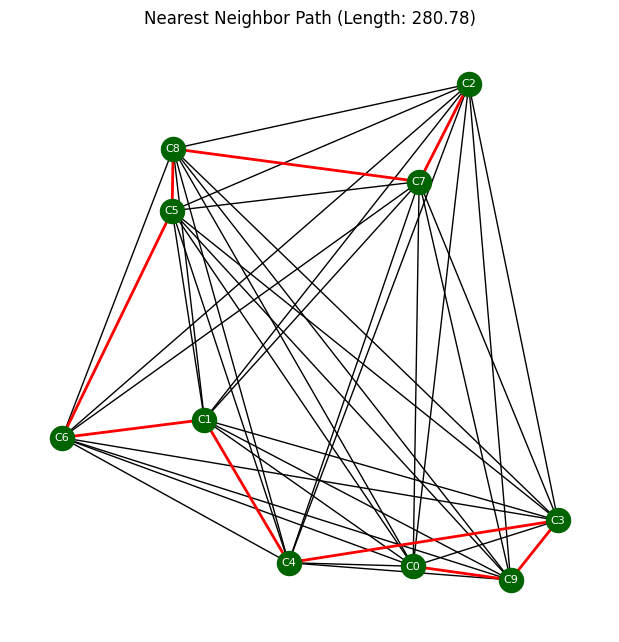

In [71]:

def nearest_neighbor(G : nx.Graph) -> tuple[list[str], float]:
    n = NUM_CITIES
    first = list(G.nodes)[0]

    #initialize route at the first node
    route = [first] 
    visited = {first}
    best_distance = 0
    while len(visited) < n: 
        current_node = route[-1]
        #Finds the nearest node to the current node that has not been visited yet
        nearest_node, distance = min([(i, distances[current_node][i]) for i in G[current_node] if i not in visited], key=lambda x: x[1])

        route.append(nearest_node)
        visited.add(nearest_node)
        best_distance += distance
    else:
        #Connect last node distance to the first node distance
        best_distance += distances[current_node][first]
    return (route, best_distance)

start = time.time()
nn_path, nn_length = nearest_neighbor(G)
nn_time = time.time() - start
print(f"Nearest Neighbor Time: {(nn_time * 1000):.4f}ms | Best Distance: {nn_length} Path: {nn_path}")

plt.figure(figsize=(6,6))
nx.draw(G, pos, with_labels=True, node_size=300, font_color='white', font_size=8, node_color='darkgreen')

# Draw the NN path in red
nn_edges = [(nn_path[i], nn_path[i+1]) for i in range(len(nn_path)-1)]
nx.draw_networkx_edges(G, pos, edgelist=nn_edges, edge_color='red', width=2)

# Title
plt.title(f"Nearest Neighbor Path (Length: {nn_length:.2f})")
plt.axis('off')
plt.show()

## Genetic Algorithm

1. Generate random population from the list of cities
2. Create a new population
   - Select two random parent from population *(tournament selection)*
   - Perform crossover *(Ordered Crossover)* to get an offspring
   - Perform mutation based on probability
   - Add offspring to new population
3. Record the best tour of each new population and compare to the best
4. Repeat step 2-3 until max generations
5. Return the best recorded tour

*References*
[Crossover Methods](https://mat.uab.cat/~alseda/MasterOpt/GeneticOperations.pdf)





Time: 1.3255479335784912, Distance: 264.13887564142317
Path: ('C7', 'C2', 'C8', 'C5', 'C6', 'C1', 'C4', 'C0', 'C9', 'C3')


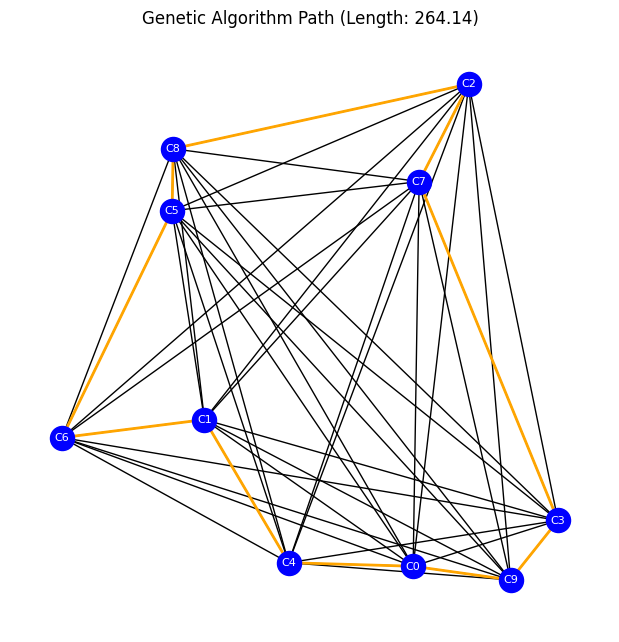

In [72]:
from functools import cache



def genetic_alg(G: nx.Graph, pop_size: int, mutation_rate: float, generations: int) -> tuple[list, float]:
    # Initialize a random population
    nodes = list(G.nodes)
    
    def random_population(nodes: list, size: int):
        return [tuple(random.sample(nodes, len(nodes))) for _ in range(size)]

    def crossover(parent1: list, parent2: list):
        # Uses OX crossover method
        size = len(nodes)
        start, end = sorted(random.sample(range(size), 2))
        
        child  = [None] * size
        # Step 1: Copy a substring from parent1
        child[start:end] = parent1[start:end]

        # Step 2: Fill remaining from parent2
        p2_idx = 0
        for i in range(size):
            if child[i] is None:
                while parent2[p2_idx] in child:
                    p2_idx += 1
                child[i] = parent2[p2_idx]
        return tuple(child)
    
    def mutate(route : tuple):
        route = list(route)[:]
        if random.random() < mutation_rate:
            i, j = random.sample(range(len(nodes)), 2)
            route[i], route[j] = route[j], route[i]
        return tuple(route)
    
    def get_parents(population: list[tuple], fitness: list[float]) -> tuple[tuple,tuple]:
        # Tournament selection for parent
        # Selects the top 2 among random 6 individuals.
        candidates = random.choices(list(zip(population, fitness)), k=6)
        candidates.sort(key=lambda x: x[1], reverse=True)
        return (candidates[0][0], candidates[1][0])
    @cache
    def get_length(tour: tuple) -> float:
        return tour_length(tour)
    @cache
    def fitness(tour : tuple) -> float:
        return 1 / get_length(tour)

    population = random_population(nodes, pop_size)
    pop_fitness = [fitness(x) for x in population]
    best_distance = float('Inf')
    best_tour: tuple = None

    for gen in range(generations):
        new_population: list[list] = []
        for _ in range(pop_size):
            p1, p2 = get_parents(population, pop_fitness)
            child = crossover(p1, p2)
            child = mutate(child)
            new_population.append(child)
        population = new_population
        pop_fitness = [fitness(x) for x in new_population]

        current_best_tour = min(list(zip(population, pop_fitness)), key=lambda r: r[1])[0]
        current_best_distance = get_length(current_best_tour)
        if current_best_distance < best_distance:
            best_distance = current_best_distance
            best_tour = current_best_tour
    
    return best_tour, best_distance

POP_SIZE = 100
GENERATIONS = 1000
MUTATION_RATE = 0.01
start = time.time()
tour, ga_length = genetic_alg(G, POP_SIZE, MUTATION_RATE, GENERATIONS)
ga_time = time.time() - start
print(f"Time: {ga_time}, Distance: {ga_length}")

# Add the final return to start node for visualization
ga_path = list(tour) + [tour[0]]

# Output and Visual
print(f"Path: {tour}")

# Visualize the Genetic Algorithm result
plt.figure(figsize=(6, 6))
nx.draw(G, pos, with_labels=True, node_size=300, font_color='white', font_size=8, node_color='blue')

# Draw the best GA path
ga_edges = [(ga_path[i], ga_path[i+1]) for i in range(len(ga_path) - 1)]
nx.draw_networkx_edges(G, pos, edgelist=ga_edges, edge_color='orange', width=2)

# Title
plt.title(f"Genetic Algorithm Path (Length: {ga_length:.2f})")
plt.axis('off')
plt.show()


## Simulated Annealing (feel free to replace)


1. Select a random tour and calculate its distance
2. Repeat the following til max iterations:
    - Select a neighbor of the current tour (2-opt, swap two random cities in the tour)
      - if new neighbor has less distance than current tour, make it the current tour
      - if new neighbor has greater distance, calculate a probability based on temperature that it will be selected as the current tour
    - Lower temperature by alpha
3. Return the recorded best tour

In [73]:
T, ALPHA, ITER = 10000, 0.995, 20000
def total_distance(path, distances, cities): # Add cities as an argument
    """Calculate total distance of a tour/path."""
    n = len(path)
    total_dist = 0
    for i in range(n):
        city1 = list(cities.keys())[path[i]] # Get city name using index from path
        city2 = list(cities.keys())[path[(i + 1) % n]] # Get next city name
        total_dist += distances[city1][city2]  # Access distances using city names
    return total_dist

def simulated_annealing(cities, distances, T=10000, ALPHA=0.995, ITER=20000):
    """Simulated Annealing algorithm for the TSP problem."""
    n = len(cities)

    # Start with a random path
    current_solution = list(range(n))
    random.shuffle(current_solution)
    current_cost = total_distance(current_solution, distances, cities) # Pass cities to total_distance

    best_solution = list(current_solution)
    best_cost = current_cost

    temp = T
    for iteration in range(ITER):
        # Swap two cities to get a new solution
        i, j = random.sample(range(n), 2)
        new_solution = list(current_solution)
        new_solution[i], new_solution[j] = new_solution[j], new_solution[i]

        new_cost = total_distance(new_solution, distances, cities) # Pass cities to total_distance
        delta = new_cost - current_cost

        # Accept the new solution if it's better or with a probability
        if delta < 0 or random.random() < math.exp(-delta / temp):
            current_solution = new_solution
            current_cost = new_cost

            if current_cost < best_cost:
                best_solution = current_solution
                best_cost = current_cost

        temp *= ALPHA

    return best_solution, best_cost # Return the solution and its cost

Simulated Annealing:
Path: [0, 4, 1, 6, 5, 8, 2, 7, 3, 9]
Total Distance: 264.13887564142317
Execution Time: 0.24249601364135742 seconds


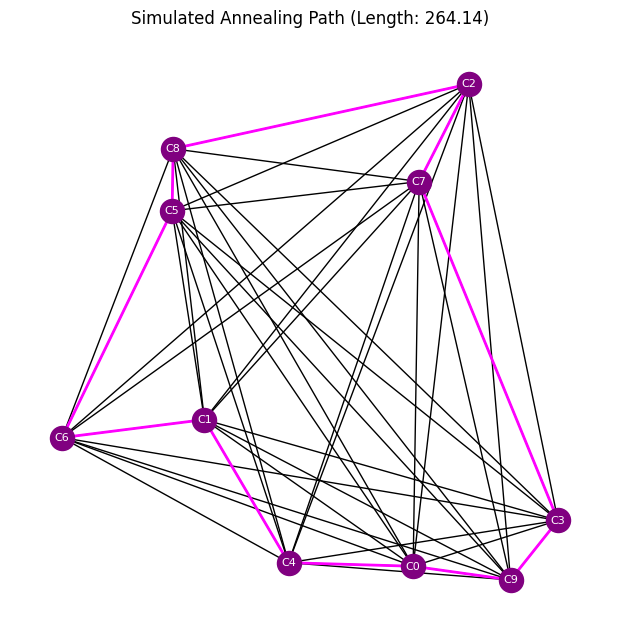

In [77]:
import pandas as pd

start = time.time()
sa_path, sa_length = simulated_annealing(cities, distances, T=10000, ALPHA=0.995, ITER=20000)
sa_time = time.time() - start


print("Simulated Annealing:")
print("Path:", sa_path)
print("Total Distance:", sa_length)
print("Execution Time:", sa_time, "seconds")

# Convert index-based path to city names
city_names = list(cities.keys())
sa_named_path = [city_names[i] for i in sa_path] + [city_names[sa_path[0]]]  # to close the tour


# Visualize the path
plt.figure(figsize=(6, 6))
nx.draw(G, pos, with_labels=True, node_size=300, font_color='white', font_size=8, node_color='purple')

# Draw the SA path
sa_edges = [(sa_named_path[i], sa_named_path[i+1]) for i in range(len(sa_named_path) - 1)]
nx.draw_networkx_edges(G, pos, edgelist=sa_edges, edge_color='magenta', width=2)

# Title
plt.title(f"Simulated Annealing Path (Length: {sa_length:.2f})")
plt.axis('off')
plt.show()


## Ant Colony Optimization


1. Initialize an nxn pheromone matrix with values 1
2. Repeat until max epochs:
    - For each ants:
      - Select a random starting city
      - Calculate the probabilities of the next city to visit based on pheromone matrix, alpha, beta
      - Select the next city based on weighted probability
      - Record as the best tour if its the least distance
      - Repeat until all cities are visited
    - Reduce the pheromones by rho (1 - rho)
    - Deposit pheromones on each calculated tours based on q and distance of tour
3. Return the best recorded tour


Best tour found: ['C1', np.str_('C4'), np.str_('C0'), np.str_('C9'), np.str_('C3'), np.str_('C7'), np.str_('C2'), np.str_('C8'), np.str_('C5'), np.str_('C6')]
C1 -> C4 -> C0 -> C9 -> C3 -> C7 -> C2 -> C8 -> C5 -> C6
Tour length: 264.14
Time taken: 0.3757 seconds


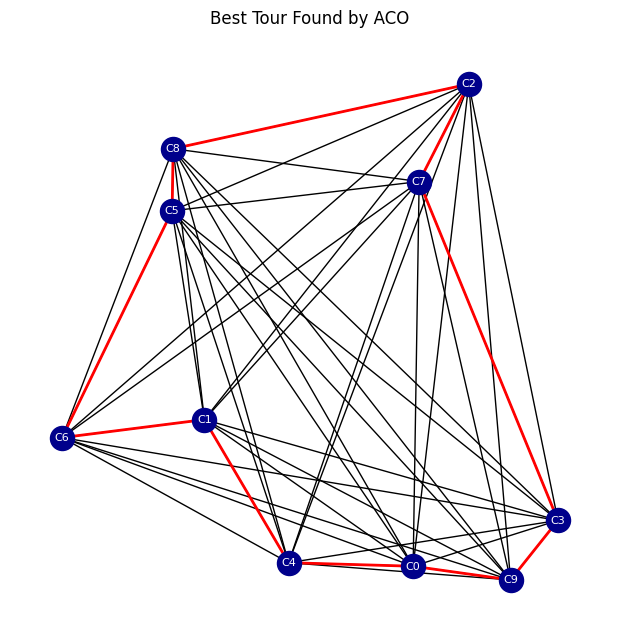

In [ ]:
import time

# ACO Parameters
NUM_ANTS = 20
EPOCH = 50
ALPHA = 1.0
BETA = 5.0
RHO = 0.1
Q = 100

# Initialize pheromone levels
pheromones = {u: {v: 1.0 for v in cities} for u in cities}

# ACO Helper: Probability of choosing the next city
def choose_next_city(current_city, unvisited, pheromones, distances):
    probabilities = []
    for city in unvisited:
        tau = pheromones[current_city][city] ** ALPHA
        eta = (1.0 / distances[current_city][city]) ** BETA
        probabilities.append(tau * eta)
    total = sum(probabilities)
    probabilities = [p / total for p in probabilities]
    return np.random.choice(list(unvisited), p=probabilities)

# Start timer
start_time = time.time()

# ACO Core
best_tour = None
best_length = float('inf')

for iteration in range(EPOCH):
    all_tours = []
    all_lengths = []

    for _ in range(NUM_ANTS):
        start = random.choice(list(cities.keys()))
        unvisited = set(cities.keys()) - {start}
        tour = [start]

        current = start
        while unvisited:
            next_city = choose_next_city(current, unvisited, pheromones, distances)
            tour.append(next_city)
            unvisited.remove(next_city)
            current = next_city
        tour_length_val = tour_length(tour)
        all_tours.append(tour)
        all_lengths.append(tour_length_val)

        if tour_length_val < best_length:
            best_length = tour_length_val
            best_tour = tour

    # Evaporate pheromones
    for u in pheromones:
        for v in pheromones[u]:
            pheromones[u][v] *= (1 - RHO)

    # Deposit pheromones
    for tour, length in zip(all_tours, all_lengths):
        for i in range(len(tour)):
            u, v = tour[i], tour[(i + 1) % len(tour)]
            pheromones[u][v] += Q / length
            pheromones[v][u] += Q / length

# End timer
end_time = time.time()
elapsed_time = end_time - start_time

# Output the result
print(f"Best tour found:")
print(",".join(best_tour))
print(f"Tour length: {best_length:.2f}")
print(f"Time taken: {elapsed_time:.4f} seconds")

# Visualize
plt.figure(figsize=(6,6))
nx.draw(G, pos, with_labels=True, node_size=300, font_size=8, font_color='white', node_color='darkblue')
edges = [(best_tour[i], best_tour[(i+1)%len(best_tour)]) for i in range(len(best_tour))]
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='red', width=2)
plt.title("Best Tour Found by ACO")
plt.axis('off')
plt.show()

aco_length = best_length
aco_time = elapsed_time

Algorithm            |   Distance |  Time(s)
---------------------------------------------
Brute Force          |     264.14 |   9.3329
Nearest Neighbor     |     280.78 |   0.0000
Genetic Algorithm    |     264.14 |   1.3255
Simulated Annealing  |     264.14 |   0.1839
Ant Colony           |     264.14 |   0.3708


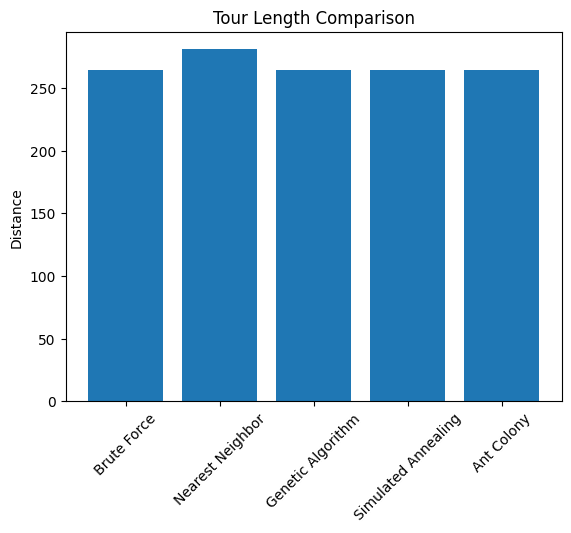

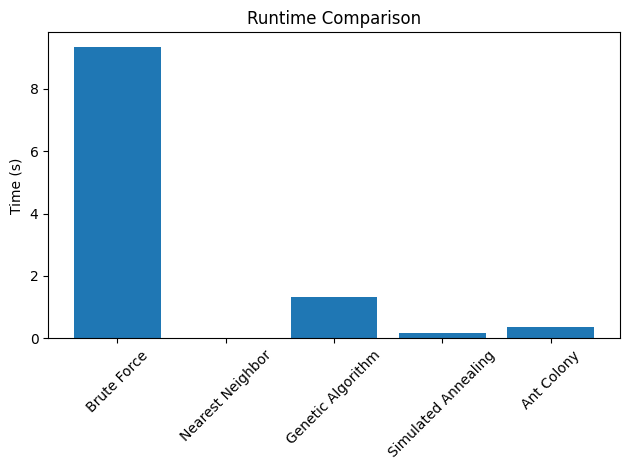

In [76]:
results = [
    ('Brute Force', best_length, brute_time),
    ('Nearest Neighbor', nn_length, nn_time),
    ('Genetic Algorithm', ga_length, ga_time),
    ('Simulated Annealing', sa_length, sa_time),
    ('Ant Colony', aco_length, aco_time)
]

# Table
print(f"{'Algorithm':20s} | {'Distance':>10s} | {'Time(s)':>8s}")
print('-'*45)
for name, dist, t in results:
    print(f"{name:20s} | {dist:10.2f} | {t:8.4f}")

# Charts
labels = [r[0] for r in results]
distances_cmp = [r[1] for r in results]
times_cmp = [r[2] for r in results]

plt.figure()
plt.bar(labels, distances_cmp)
plt.title('Tour Length Comparison')
plt.ylabel('Distance')
plt.xticks(rotation=45)

plt.figure()
plt.bar(labels, times_cmp)
plt.title('Runtime Comparison')
plt.ylabel('Time (s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()